In [1]:
# Agents, only for discrete control

# from utils import make_env, default_atari_preprocessing
import gym
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import gym_minatar
from tqdm import tqdm


import numpy as np

# Generic replay buffer for standard gym tasks
class StandardBuffer(object):
    def __init__(self, state_shape, buffer_size, device):
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size, *state_shape))
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.zeros((self.max_size, *state_shape))
        # self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.not_done = np.zeros((self.max_size, 1))


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self, batch_size=32):
        ind = np.random.randint(0, self.crt_size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
        )


    def save(self, save_folder):
        np.save(f"{save_folder}_state.npy", self.state[:self.crt_size])
        np.save(f"{save_folder}_action.npy", self.action[:self.crt_size])
        np.save(f"{save_folder}_next_state.npy", self.next_state[:self.crt_size])
        np.save(f"{save_folder}_reward.npy", self.reward[:self.crt_size])
        np.save(f"{save_folder}_not_done.npy", self.not_done[:self.crt_size])
        np.save(f"{save_folder}_ptr.npy", self.ptr)


    def load(self, save_folder, size=-1):
        reward_buffer = np.load(f"{save_folder}_reward.npy")

        # Adjust crt_size if we're using a custom size
        size = min(int(size), self.max_size) if size > 0 else self.max_size
        self.crt_size = min(reward_buffer.shape[0], size)

        self.state[:self.crt_size] = np.load(f"{save_folder}_state.npy")[:self.crt_size]
        self.action[:self.crt_size] = np.load(f"{save_folder}_action.npy")[:self.crt_size]
        self.next_state[:self.crt_size] = np.load(f"{save_folder}_next_state.npy")[:self.crt_size]
        self.reward[:self.crt_size] = reward_buffer[:self.crt_size]
        self.not_done[:self.crt_size] = np.load(f"{save_folder}_not_done.npy")[:self.crt_size]
        print(f"Replay Buffer loaded with {self.crt_size} elements.")

# this conv encoder is only for fourrooms
class ConvEncoder(nn.Module):
    def __init__(
        self,
        state_shape, # ex (4, 84, 84), (3, 7, 7)
        latent_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.state_shape = state_shape
        self.latent_dim = latent_dim
        
        def make_dummy_conv():
            encoder = nn.Linear(self.state_shape[0], self.latent_dim).to(device)
            return encoder
            
        def make_conv():
            conv = nn.Sequential(nn.Conv2d(state_shape[0], 32, 3, stride=1),
                                     nn.ReLU(), nn.Conv2d(32, 16, 3, stride=1),
                                     nn.ReLU()).to(device)
            sample = torch.zeros(1, *state_shape).to(device)
            size = torch.flatten(conv(sample)).shape[-1]
            encoder = nn.Sequential(conv, nn.Flatten(), nn.Linear(size, self.latent_dim), nn.ReLU()).to(device)
            return encoder
        
        if len(self.state_shape) < 2:
            self.encoder = make_dummy_conv()
        else:
            self.encoder = make_conv()
            
    def forward(self, state):
        return self.encoder(state)
    

class Phi(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        sf_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.phi = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
                              nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                              nn.Linear(hidden_dim, sf_dim)).to(device)
        
    def forward(self, latent, norm=True):
        # in APS, we need to normalize the output
        out = self.phi(latent)
        out = F.normalize(out, dim=-1) if norm else out
        return out
    
class Critic(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        num_actions,
        sf_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device
        self.num_actions = num_actions
        self.sf_dim = sf_dim
        
        def make_critic():
            Q = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
                              nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                              nn.Linear(hidden_dim, num_actions * sf_dim)).to(device)
            return Q
        
        self.Q1 = make_critic()
        self.Q2 = make_critic()
        
    def forward(self, latent): # for general SF update
        return (
            self.Q1(latent).view(-1, self.num_actions, self.sf_dim).squeeze(-1),
            self.Q2(latent).view(-1, self.num_actions, self.sf_dim).squeeze(-1)
        )
    
    def get_SF1(self, latent):
        return self.Q1(latent).view(-1, self.num_actions, self.sf_dim).squeeze(-1)
    
    def get_SFs(self, latent):
        return (
            self.Q1(latent).view(-1, self.num_actions, self.sf_dim).squeeze(-1),
            self.Q2(latent).view(-1, self.num_actions, self.sf_dim).squeeze(-1)
        )
    
    def get_Qs(self, latent, task): # for implicit SF update
        SF1, SF2 = self.get_SFs(latent)
        return (
            torch.einsum("bi,bji->bj", task, SF1).view(-1, self.num_actions),
            torch.einsum("bi,bji->bj", task, SF2).view(-1, self.num_actions),
        )
    
    def get_Q1(self, latent, task): # for picking actions based on Q
        SF1 = self.get_SF1(latent)
        return torch.einsum("bi,bji->bj", task, SF1).view(-1, self.num_actions)

    
class MiniAtarWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # self.observation_space = gym.spaces.Box(low=np.zeros((1, 13, 13)), high=np.ones((1, 13, 13)), dtype=np.uint8)
        # self.observation_space = gym.spaces.Box(low=np.zeros((7, 10, 10)), high=np.ones((7, 10, 10)), dtype=np.float32)
        size = env.observation_space.shape[-1]
        self.size = size
        low = env.observation_space.low.reshape((size, 10, 10))
        high = env.observation_space.high.reshape((size, 10, 10))
        dtype = env.observation_space.dtype
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=dtype)
    
    def observation(self, state):
        return state.transpose(2, 0, 1)

class DQN:
    def __init__(
        self,
        env,
        discount=0.99,
        lr_critic=1e-4,
        lr_encoder=1e-4,
        latent_dim=256,
        hidden_dim=256,
        initial_eps=1,
        end_eps=0.1,
        eval_eps=0.1,
        pretrain_eps=0.1,
        eps_decay_period=int(2e4),
        target_update_frequency=200,
        double_q=False,
    ):
        # store input values
        self.conv = True
        self.env = MiniAtarWrapper(env)
        # self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.discount = discount
        self.lr_critic = lr_critic
        self.lr_encoder = lr_encoder
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.initial_eps = initial_eps
        self.end_eps = end_eps
        self.eval_eps = eval_eps
        self.pretrain_eps = pretrain_eps 
        self.eps_decay_period = eps_decay_period
        self.target_update_frequency = target_update_frequency
        self.double_q = double_q
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # calculate some important values
        self.slope = (self.end_eps - self.initial_eps) / self.eps_decay_period
        
        # keep track of some important info
        self.iterations = 0
        
        # define networks
        self._define_networks()
        self._make_alias()
        
    def _make_alias(self):
        self.Q = self.critic.get_SF1
        self.Q_target = self.critic_target.get_SF1
                
    def _define_networks(self):
        self.encoder = ConvEncoder(
            state_shape=self.state_shape,
            latent_dim=self.latent_dim,
        )
        
        self.critic = Critic(
            latent_dim=self.latent_dim, 
            hidden_dim=self.hidden_dim, 
            num_actions=self.num_actions,
            sf_dim=1
        )
        self.critic_target = copy.deepcopy(self.critic)
        
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters(), lr=self.lr_encoder)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
    def make_replay_buffer(self, buffer_size):
        return StandardBuffer(self.state_shape, buffer_size, self.device)
    
    def select_action(self, state, eval=False, pretrain=False):
        if eval: # if eval, we don't care if we are pretraining or not
            eps = self.eval_eps
        elif pretrain: # if pretrain, we use pretrain eps
            eps = self.pretrain_eps
        else:
            eps = max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)
                # print(state)
                # print(self.encoder)
                latent = self.encoder(state)
                return int(self.Q(latent).argmax(1))
        else:
            return np.random.randint(self.num_actions)
    
    def train(self, replay_buffer, batch_size=32, fine_tune=False):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size=batch_size)
        
        latent = self.encoder(state)
        next_latent = self.encoder(next_state)
        
        # calcualte the q-target
        with torch.no_grad():
            next_action = self.critic.get_SF1(next_latent).argmax(1, keepdim=True)
            if self.double_q:
                target_Q1, target_Q2 = self.critic_target(next_latent)
                target_Q1, target_Q2 = (
                    target_Q1.gather(1, next_action).view(-1, 1),
                    target_Q2.gather(1, next_action).view(-1, 1)
                )
                target_Q = torch.min(target_Q1, target_Q2)
            else:
                target_Q = self.critic_target.get_SF1(next_latent).gather(1, next_action).view(-1, 1)
                
            target_Q = reward + not_done * self.discount * target_Q
        
        if self.double_q:
            Q1, Q2 = self.critic(latent)
            Q1, Q2 = (
                Q1.gather(1, action).view(-1, 1),
                Q2.gather(1, action).view(-1, 1)
            )
            
            Q_loss = F.smooth_l1_loss(Q1, target_Q) + F.smooth_l1_loss(Q2, target_Q)
        else:
            Q = self.critic.get_SF1(latent).gather(1, action).view(-1, 1)
            Q_loss = F.smooth_l1_loss(Q, target_Q)
                
        
        # update encoder and the critic        
        self.encoder_opt.zero_grad()
        self.critic_opt.zero_grad()
        Q_loss.backward()
        self.encoder_opt.step()
        self.critic_opt.step()
        
        self.iterations += 1
        
        # update the target network
        self.copy_target_update()
        
    def learn(self, replay_buffer, step_size, expl_step_size, batch_size=32, fine_tune=False, log_freq=int(1e3)):
        state = self.env.reset()
        episodic_return = 0
        episode_length = 0
        episode_num = 0
        
        evaluations = []
        
        for step in range(step_size):
            # pick action and transit in the env
            if step < expl_step_size:
                action = self.env.action_space.sample()
            else:
                action = self.select_action(state, eval=False, pretrain=False)
                
            next_state, reward, done, info = self.env.step(action)
            
            # add the experience into the buffer
            replay_buffer.add(state, action, next_state, reward, done)
            self.train(replay_buffer, batch_size=batch_size, fine_tune=fine_tune)
            
            # update iterative values
            state = next_state
            episodic_return += reward
            episode_length += 1
            
            if (step + 1) % log_freq == 0:
                evaluations.append(self.evaluate())
            
            # check if the episode ends
            if done:
                print(f"====== Total T: {step+1} Episode Num: {episode_num+1} Episode_Length T: {episode_length} Return: {episodic_return:.3f} ======")
                episode_num += 1
                state = self.env.reset()
                episodic_return = 0
                episode_length = 0
                
        return evaluations
                
    def evaluate(self, seed=0, eval_episodes=10):
        eval_env = copy.deepcopy(self.env)
        eval_env.seed(seed + 100)

        avg_reward = 0.
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state), eval=True)
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

    def polyak_target_update(self):
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def copy_target_update(self):
        if self.iterations % self.target_update_frequency == 0:
                self.critic_target.load_state_dict(self.critic.state_dict())

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_Q")
        torch.save(self.critic_opt.state_dict(), filename + "_optimizer")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(f"{filename}"))
        self.critic_target = copy.deepcopy(self.critic)
        #self.Q_optimizer.load_state_dict(torch.load(filename + "optimizer"))

In [2]:
import gym

# env = gym.make('SpaceInvaders-MinAtar-v0')
env = gym.make('Breakout-MinAtar-v0')
print(env.observation_space.shape)
agent = DQN(
    env,
    eval_eps=0,
    lr_critic=3e-4,
    target_update_frequency=100,
)

(10, 10, 4)


In [4]:
agent.encoder

ConvEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=576, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [3]:
replay_buffer = agent.make_replay_buffer(buffer_size=int(1e5))
evaluations = agent.learn(
    replay_buffer,
    step_size=int(1e5),
    expl_step_size=int(2e3),
    log_freq=int(1e3),
)

====== Total T: 6 Episode Num: 1 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 22 Episode Num: 2 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 38 Episode Num: 3 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 44 Episode Num: 4 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 50 Episode Num: 5 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 66 Episode Num: 6 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 82 Episode Num: 7 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 98 Episode Num: 8 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 114 Episode Num: 9 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 120 Episode Num: 10 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 126 Episode Num: 11 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 142 Episode Num: 12 Episode_Length T: 16 Return: 1.000 ======
====== Total T: 148 Episode Num: 13 Episode_Length T: 6 Return: 0.000 ======
====== Tot

Text(0.5, 1.0, 'Breakout-DQN')

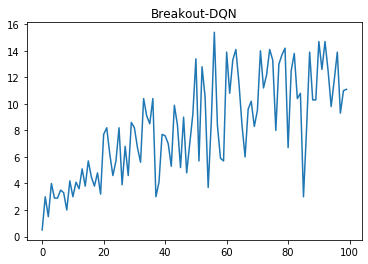

In [4]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('Breakout-DQN')

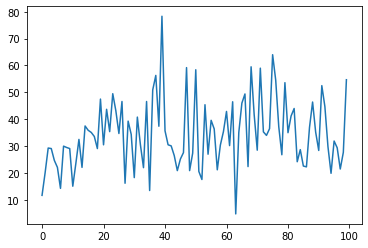

In [7]:
import matplotlib.pyplot as plt

plt.plot(evaluations)

In [64]:
replay_buffer = agent.make_replay_buffer(buffer_size=int(1e5))
agent.learn(
    replay_buffer,
    step_size=int(1e6),
    expl_step_size=int(5e3),
    log_freq=int(1e4),
)

====== Total T: 23 Episode Num: 1 Episode_Length T: 23 Return: 0.000 ======
====== Total T: 113 Episode Num: 2 Episode_Length T: 90 Return: 1.000 ======
====== Total T: 118 Episode Num: 3 Episode_Length T: 5 Return: 0.000 ======
====== Total T: 124 Episode Num: 4 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 156 Episode Num: 5 Episode_Length T: 32 Return: 0.000 ======
====== Total T: 158 Episode Num: 6 Episode_Length T: 2 Return: 0.000 ======
====== Total T: 276 Episode Num: 7 Episode_Length T: 118 Return: 0.000 ======
====== Total T: 417 Episode Num: 8 Episode_Length T: 141 Return: 2.000 ======
====== Total T: 449 Episode Num: 9 Episode_Length T: 32 Return: 0.000 ======
====== Total T: 459 Episode Num: 10 Episode_Length T: 10 Return: 0.000 ======
====== Total T: 465 Episode Num: 11 Episode_Length T: 6 Return: 0.000 ======
====== Total T: 479 Episode Num: 12 Episode_Length T: 14 Return: 0.000 ======
====== Total T: 486 Episode Num: 13 Episode_Length T: 7 Return: 0.000 ======

KeyboardInterrupt: 

In [31]:
env.observation_space.shape

(10, 10, 7)